# Working with "irregular" Datafiles

This notebook gives an example how to read "irregular" datafiles using `qpcr.Readers`.
It makes use of the provided example data in the `Example Data` directory. 


#### Experimental background

The corresponding experimental setup was as follows: 
Levels of Nonsense-mediated mRNA decay (NMD) sensitive (nmd) and insensitive (prot) transcript isoforms of HNRNPL and SRSF11 were measured by qPCR. As normalisers both 28S rRNA and Actin transcript levels were measured. The replicates are biological triplicates and technical douplicates. All measurements from the same qPCR sample were merged into hexaplicates (6 replicates). This was done in two separate HeLa cell lines (one with a specific gene knockout (KO), and one without (WT)), which were both treated to a plasmid-mediated rescue (+) or not (-), leading to four experimental conditions:


| cell line \\ condition | rescue | no rescue |
| ---------------------- | ------ | --------- |
| knockout               | KO+    | KO-       |
| wildtype               | WT+    | WT-       |

In [1]:
# import the qpcr module
import qpcr
from qpcr.Readers import SingleReader, MultiReader

1 - Reading an "irregular" single-assay datafile
---

### 1.1 Setting up the `DataReader`
First we set up the `qpcr.DataReader`

In [2]:
# our single-assay datafile
file = "./Example Data/Irregular Files/28S_irregular.csv"

# set up the reader
reader = qpcr.DataReader()

### 1.2 Specify how to read the file

This datafile is an "irregular" file but not a "Big Table" file (hence it specifies different assays as separate tables). We know (you can check out the file for yourself, if you like) the assays have a "header" in the very first column of the file (so we know where to look for assays). 

#### The `assay_pattern`
Also, we know they always follow the same kind of `pattern` (since the data was generated by QiaGen's Rotor-Gene, this "assay header" is always `"Quantitative analysis of Cycling A.<color> (<my_assay>)"`). The `qpcr.Parsers` have a way of using `regex` to find such assay headers and read the assay identifiers from them. We can either specify a `regex` pattern directly or use a pre-defined one using their `assay_pattern` method, which is available as an argument via the `DataReader`. For this case the pattern is already implemented and can be accessed through the key `"Rotor-Gene"`. 

#### Data columns
We would also have to specify what the column names of the replicate identifiers and Ct values are. In this case the column names are `"Name"` for the identifiers and `"Ct"` for the Ct values (note that these are also the default that will be used if using the `DataReader`).

In [3]:
assay = reader.read(
                        filename = file, 

                        # specify the assay pattern from the file
                        assay_pattern = "Rotor-Gene",
                        
                        # specify the column where assay headers are 
                        # (this is the default)
                        col = 0, 

                        # specify the column names of the data columns 
                        # (these are actually the defaults)
                        id_label = "Name",
                        ct_label = "Ct"
                )

In [4]:
# check what assay we got (it should be 28S)
assay.id()

'28S'

### 1.3 Using the `qpcr.Readers.SingleReader` directly

Of course, the `DataReader` did not actually read anything by itself. It simply looked at our provided specifics and decided to call on the `qpcr.Readers.SingleReader` to our file.  
We could avoid the little computation required for Reader-inferencing by directly using the `qpcr.Readers.SingleReader`. 

Here's how:

We first set up the reader and then use it's `pipe` method to read the data and get a `qpcr.Assay` object. In fact, this is just what the `DataReader` did for us before.

In [5]:
reader = SingleReader()

# read the file
# this time we omit the specifics that are defaults anyway
assay = reader.pipe(
                        filename = file, 
                        # specify the assay pattern from the file
                        assay_pattern = "Rotor-Gene",
                )

# and check if we still have 28S
assay

Assay(id='28S', eff=1.0, n=24)

### 1.4 Reading the Excel version
So far we worked with `csv` files, but, of course, we could also have read an `excel` version of the file. To exemplify this, we read an irregular single-assay excel file containing an ActinB assay.

In [6]:
excelfile = "./Example Data/Irregular Files/actin_irregular.xlsx"

assay = reader.pipe(
                        filename = excelfile, 
                        # specify the assay pattern from the file
                        assay_pattern = "Rotor-Gene",
                )

# and check if we still have 28S
assay

Assay(id='ACTB', eff=1.0, n=24)

2 - Reading "irregular" multi-assay files
----

What if we have multiple assays in the file? 
Well, we can easily do so using the `DataReader` for instance. To exemplify this we shall read a file that contains assays from 28S, and HNRNPL protein-coding and NMD-sensitive assays. 

### 2.1 Reading a single assay from a multi-assay datafile

Extracting a single assay from a multi-assay datafile is pretty straight forward. All we need to do is to specify which assay we are interested in using the `assay` argument, which takes in the name of the assay.

In [7]:
multi_assay_file = "./Example Data/Irregular Files/irregular_multi_assay.csv"

reader = qpcr.DataReader()

assay = reader.read(
                    filename = multi_assay_file, 

                    # specify the assay pattern from the file
                    assay_pattern = "Rotor-Gene",

                    # specify that we specifically want 28S for instance
                    assay = "28S"
                )

# check what assay we got
assay

Assay(id='28S', eff=1.0, n=24)

### 2.2 Reading multiple assays from a multi-assay datafile
If we have a multi-assay datafile then we probably want to read all these assays, right? 
No problem for the `DataReader`. You may already have noticed that it's `read` method has an argument `multi_assay` which can be set to `True` if you wish to read multiple assays from your file. 

In [8]:
assays = reader.read(
                    filename = multi_assay_file, 

                    # specify that we want multiple assays
                    multi_assay = True,

                    # specify the assay pattern from the file
                    assay_pattern = "Rotor-Gene",

                    # we need to reset the Reader that DataReader uses 
                    # as it currently thinks we are interested in 
                    # single assays (this is mainly a required technicality)
                    reset = True
                )

# check what assays we got
assays

([Assay(id='28S', eff=1.0, n=24),
  Assay(id='HNRNPL protein', eff=1.0, n=24),
  Assay(id='HNRNPL NMD', eff=1.0, n=24)],
 [])



So, you may notice that `two lists` are actually returned now, one containing three assays, the other one being empty. Why is that? 

Well, the two lists are for `"assays-of-interest"` and `"normaliser-assays"`. However, since the Reader has no way of knowing which of our assays is actually a normaliser an which is not, all assays are assigned to the "assays-of-interest" list. 

### 2.3 - Reading "assays" and "normalisers" from multi-assay files
Well wouldn't it be nice if we could let the Reader somehow know which of our assays are actually normalisers? Luckily, we can do just that super easily by adding `decorators` to the assays in our datafile. 

Check out [the documentation](https://qpcr.readthedocs.io/en/latest/qpcr.Parsers.html#decorators) about decorators or [the later tutorial](https://qpcr.readthedocs.io/en/latest/tutorials/8_decorating_datafiles.html) about it to learn how to do this. 

> Note
>
> Once we have decorated our assays we can even omit the `assay_pattern` argument if we want to, since the Reader (or, more acurately, the Parser that is being called by the Reader to extract the data) now knows what to look for (i.e. the decorators).

In [9]:
decorated_multi_assay_file = "./Example Data/Irregular Files/irregular_multi_assay_decorated.xlsx"


assays = reader.read(
                    filename = decorated_multi_assay_file, 

                    # specify that we want multiple assays
                    multi_assay = True,

                    # specify that the assays are decorated
                    decorator = True,

                    # specify the assay pattern from the file
                    assay_pattern = "Rotor-Gene",
                )

# check what assays we got
assays

([Assay(id='HNRNPL protein', eff=1.0, n=24),
  Assay(id='HNRNPL NMD', eff=1.0, n=24)],
 [Assay(id='28S', eff=1.0, n=24)])



Notice how the first list now only has two `qpcr.Assay` objects while the second one now has one? This is because the Reader now knew that 28S was actually supposed to be a normaliser and not an assay-of-interest.

> Note
>
> Boolean `decorator` arguments only work for multi_assay files when using a `Reader` (they will not work for `Parsers`). If you wish to use decorators to get specific assays using a `Reader` or want to use decorators with a `Parser` you have to specify an actual decorator key! The save alternative to `decorator = True` is `decorator = "qpcr:all"` which will always work and have the same effect.

### 2.5 - Using the `qpcr.Readers.MultiReader` directly

Naturally, just as with the `SingleReader` we can also use the `MultiReader` directly and do not have to rely on the `qpcr.DataReader`!

In [10]:
reader = MultiReader()

assays, normalisers = reader.pipe(
                                    filename = decorated_multi_assay_file, 

                                    # specify that the assays are decorated
                                    decorator = True,

                                    # specify the assay pattern from the file
                                    assay_pattern = "Rotor-Gene",
                                )

assays

[Assay(id='HNRNPL protein', eff=1.0, n=24),
 Assay(id='HNRNPL NMD', eff=1.0, n=24)]

### 2.6 - Extracting only specific assays from a multi-assay file
If you only wish extract specific assays you can either just read them all and then discard those you don't care about (this probably most straightforward), or decorate them and specify which decorator to extract.

In fact, using a `Reader` you will *always* be extracting both assays and normalisers if possible. 

In case you really only want to read some specific assays you have two options: 

1. Only decorate the assays you are intersted in, because *any non-decorated* assays will be ignored if you specify that your data is decorated! 

2. If you really want to decorate all assays, but you only want to extract a subset of them you
can use the `qpcr.Parsers` directly. Note that in this case you will have to use different decorators, of course, for the ones you are interested in vs the ones you don't care about.

Here we will only extract the as "assays" decorated datasets from the file and ignore the ones decorated as "normalisers".

In [11]:
from qpcr.Parsers import ExcelParser

# setup the Parser
parser = ExcelParser()

# define the assay pattern
parser.assay_pattern("Rotor-Gene")


# specify that we are only interested 
# in as assay decorated datasets
decorator = "qpcr:assay"

# pipe the file through the parser
assays = parser.pipe( 
                        filename = decorated_multi_assay_file,

                        # specify what decorators we are interested in
                        decorator = decorator
                )


# now we have a dictionary of assay 
# identifiers and their dataframes
assays.keys()


dict_keys(['HNRNPL protein', 'HNRNPL NMD'])

> Note
>
> The `Parsers` return dictionaries of pandas DataFrames, not `qpcr.Assay` objects!

We can now convert the dictionary to `qpcr.Assay` objects by:

In [12]:
assays = [ qpcr.Assay(df, id) for id, df in assays.items() ]

assays

[Assay(id='HNRNPL protein', eff=1.0, n=24),
 Assay(id='HNRNPL NMD', eff=1.0, n=24)]

3 Delta-Delta-Ct directly from a decorated multi-assay file
---

Currently, we can't actually use pipelines like `BasicPlus` from the `qpcr.Pipes` directly to analyse multi-assay datafiles because, even though the pipelines rely on the `qpcr.DataReader`, their workflow architecture assumes to work with multiple datafiles! 

But don't worry, there is one pipeline that thinks out of the box. That's the `ddCt` pipeline. It will not require multiple datafiles as input but simply multiple `qpcr.Assay` objects directly, no matter where they came from. `ddCt` will perform filtering, delta-Ct, normalisation, and plotting, all in one go. The only thing left for you is to call the `qpcr.DataReader` to generate the `qpcr.Assay` objects. 

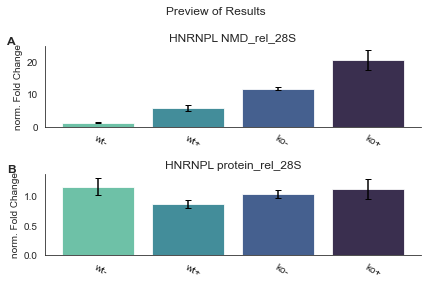

In [13]:
from qpcr.Pipes import ddCt
from qpcr.Plotters import PreviewResults

# read the datafile
reader = qpcr.DataReader()

assays, normalisers = reader.read(
                                    filename = decorated_multi_assay_file, 
                                    
                                    multi_assay = True,
                                    decorator = True, 
                                    assay_pattern = "Rotor-Gene",

                                    replicates = 6, 
                                    names = ["wt-", "wt+", "ko-", "ko+"]
                                )

# set up the ddCt pipeline
pipe = ddCt()

pipe.add_assays(assays)
pipe.add_normalisers(normalisers)

preview = PreviewResults(mode = "static")
pipe.add_plotters(preview)

pipe.run()


There is actually a slight shortcut via the `DataReader.read_multi_assay` method that will automatically fill in `multi_assay = True`. Although this may appear admittedly a negligeable time-save considering the many other arguments required.

And there we are, all done in one go! The `ddCt` pipeline is really useful because it is actually built as a derivative of the `Blueprint` pipeline, so it allows you to customise both the `Analyser` and `Normaliser` that it uses.  